<a href="https://colab.research.google.com/github/Avocado1111ca/rust_detection2/blob/main/rust1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Ultralytics の出力先を Drive に固定

In [ ]:
!yolo settings runs_dir=/content/drive/MyDrive/yolo_runs

/bin/bash: line 1: yolo: command not found


必要ライブラリのインストール

In [ ]:
!pip install -q ultralytics roboflow pycocotools opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 

路径と Roboflow 情報

In [ ]:
# ★自分の値に置き換え
API_KEY   = "隠してる"              # ←鍵は他人に見せない
WORKSPACE = "rust-wnu8c"
PROJECT   = "rust-segmentation-rfyuf"
VERSION   = 1                           # Roboflow のデータバージョン

ROOT = "/content/drive/MyDrive/datasets/Rust-Segmentation"  # Drive 上に保存

データ取得（COCO セグメンテーションでDL → Driveにコピー）

In [ ]:
import os, shutil
from roboflow import Roboflow
os.makedirs(ROOT, exist_ok=True)

rf = Roboflow(api_key=API_KEY)
project = rf.workspace(WORKSPACE).project(PROJECT)
version = project.version(VERSION)
ds = version.download("coco-segmentation")        # 例: /content/XXX に展開
shutil.copytree(ds.location, ROOT, dirs_exist_ok=True)

print("DATA ROOT:", ROOT)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rust-Segmentation-1 in coco-segmentation:: 100%|██████████| 778/778 [00:00<00:00, 5059.98it/s]


DATA ROOT: /content/drive/MyDrive/datasets/Rust-Segmentation


COCO → YOLOv8-Seg（polygon）変換 ＋ 画像を images/ 配下へ移動

In [ ]:
import os, glob, cv2, numpy as np
from pycocotools.coco import COCO

def coco_to_yolo_seg(coco_json, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    coco = COCO(coco_json)
    for img in coco.dataset['images']:
        H, W = img['height'], img['width']
        anns = coco.loadAnns(coco.getAnnIds(imgIds=[img['id']]))
        lines = []
        for a in anns:
            seg = a.get('segmentation', None)

            def add_poly(poly):
                poly = np.array(poly, dtype=np.float32).reshape(-1,2)
                if len(poly) < 3: return
                xs = (poly[:,0]/W).clip(0,1); ys=(poly[:,1]/H).clip(0,1)
                lines.append("0 " + " ".join(f"{x:.6f} {y:.6f}" for x,y in zip(xs,ys)))  # 単一クラス=0に統一

            if isinstance(seg, list) and len(seg)>0:
                if isinstance(seg[0], list):
                    for poly in seg: add_poly(poly)
                else:
                    add_poly(seg)
            else:
                mask = coco.annToMask(a).astype(np.uint8)*255
                cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                for c in cnts:
                    c = c.squeeze(1)
                    if c.ndim!=2 or len(c)<3: continue
                    xs = (c[:,0]/W).clip(0,1); ys=(c[:,1]/H).clip(0,1)
                    lines.append("0 " + " ".join(f"{x:.6f} {y:.6f}" for x,y in zip(xs,ys)))

        stem = os.path.splitext(img['file_name'])[0]
        with open(os.path.join(out_dir, stem + ".txt"), "w") as f:
            f.write("\n".join(lines))

# 変換
coco_to_yolo_seg(f"{ROOT}/train/_annotations.coco.json", f"{ROOT}/labels/train")
coco_to_yolo_seg(f"{ROOT}/valid/_annotations.coco.json", f"{ROOT}/labels/valid")
if os.path.exists(f"{ROOT}/test/_annotations.coco.json"):
    coco_to_yolo_seg(f"{ROOT}/test/_annotations.coco.json", f"{ROOT}/labels/test")

# 画像を images/ に移動（Ultralytics が images↔labels を対にして探すため）
os.makedirs(f"{ROOT}/images/train", exist_ok=True)
os.makedirs(f"{ROOT}/images/valid", exist_ok=True)
if os.path.isdir(f"{ROOT}/test"): os.makedirs(f"{ROOT}/images/test", exist_ok=True)

for ext in ("*.jpg","*.jpeg","*.png"):
    for p in glob.glob(f"{ROOT}/train/{ext}"):
        os.replace(p, f"{ROOT}/images/train/{os.path.basename(p)}")
    for p in glob.glob(f"{ROOT}/valid/{ext}"):
        os.replace(p, f"{ROOT}/images/valid/{os.path.basename(p)}")
    if os.path.isdir(f"{ROOT}/test"):
        for p in glob.glob(f"{ROOT}/test/{ext}"):
            os.replace(p, f"{ROOT}/images/test/{os.path.basename(p)}")

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


data.yaml を作成（単一クラス “rust”）

In [ ]:
yaml_text = f"""path: {ROOT}
train: images/train
val: images/valid
names: ['rust']
"""
with open(f"{ROOT}/data.yaml", "w") as f:
    f.write(yaml_text)
print(open(f"{ROOT}/data.yaml").read())

path: /content/drive/MyDrive/datasets/Rust-Segmentation
train: images/train
val: images/valid
names: ['rust']



クイック健全性チェック

In [ ]:
import os, glob
def used_class_ids(g):
    s=set()
    for p in glob.glob(g):
        for l in open(p):
            t=l.strip().split()
            if t: s.add(int(t[0]))
    return s

print("train imgs:", len(glob.glob(f"{ROOT}/images/train/*.jpg")))
print("valid imgs:", len(glob.glob(f"{ROOT}/images/valid/*.jpg")))
print("train labels:", len(glob.glob(f"{ROOT}/labels/train/*.txt")))
print("valid labels:", len(glob.glob(f"{ROOT}/labels/valid/*.txt")))
print("valid class IDs:", used_class_ids(f"{ROOT}/labels/valid/*.txt"))  # → {0} が理想

train imgs: 537
valid imgs: 153
train labels: 537
valid labels: 153
valid class IDs: {0}


学習（GPU）。途中エポックも Drive に保存（save_period）

In [ ]:
!yolo task=segment mode=train \
  model=yolov8n-seg.pt \
  data="/content/drive/MyDrive/datasets/Rust-Segmentation/data.yaml" \
  imgsz=640 epochs=50 batch=16 device=0 \
  project=/content/drive/MyDrive/yolo_runs name=rust_run1 save_period=10

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/datasets/Rust-Segmentation/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rust_run12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0

推論・可視化（Drive 上に保存）

In [ ]:
# Ultralytics の出力先設定を確認
!yolo settings | sed -n '1,120p'

# Drive 側に学習結果（.pt）があるか検索
!find "/content/drive/MyDrive/yolo_runs" -type f -name "*.pt"

# 念のため /content 側も検索（設定前に学習した場合はこちらにあることがあります）
!find /content -path "*/runs/*" -type f -name "*.pt"

JSONDict("/root/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/content/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true,
  "openvino_msg": true
}
💡 Learn more about Ultralytics Settings at https://docs.ultralytics.com/quickstart/#ultralytics-settings
/content/drive/MyDrive/yolo_runs/rust_run12/weights/last.pt
/content/drive/MyDrive/yolo_runs/rust_run12/weights/best.pt
/content/drive/MyDrive/yolo_runs/rust_run12/weights/epoch0.pt
/content/drive/MyDrive/yolo_runs/rust_run12/weights/epoch10.pt
/content/drive/MyDrive/yolo_runs/rust_run12/weights/epoch20.pt
/content/drive/MyDrive/yolo_runs/rust_run12/weights/epoch30.pt
/co

In [ ]:
!yolo task=segment mode=predict \
  model="/content/drive/MyDrive/yolo_runs/rust_run12/weights/best.pt" \
  source="/content/drive/MyDrive/datasets/Rust-Segmentation/images/valid" \
  save=True device=0 \
  project="/content/drive/MyDrive/yolo_runs" name="rust_pred12"

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs

image 1/153 /content/drive/MyDrive/datasets/Rust-Segmentation/images/valid/000185_jpg.rf.e18f936503116f6e5984db80b33891c6.jpg: 640x640 15 rusts, 17.5ms
image 2/153 /content/drive/MyDrive/datasets/Rust-Segmentation/images/valid/000185_png.rf.ee2f18dd437af81fb65bcb04ee551acc.jpg: 640x640 15 rusts, 32.8ms
image 3/153 /content/drive/MyDrive/datasets/Rust-Segmentation/images/valid/000185_png.rf.f646626362947836442ab5d47c2a9849.jpg: 640x640 16 rusts, 36.7ms
image 4/153 /content/drive/MyDrive/datasets/Rust-Segmentation/images/valid/000197_jpg.rf.38c7170395c94e4df24c91139249bc56.jpg: 640x640 4 rusts, 11.3ms
image 5/153 /content/drive/MyDrive/datasets/Rust-Segmentation/images/valid/000226_jpg.rf.249b094785b43c3d9ddf92320aece16d.jpg: 640x640 11 rusts, 13.7ms
image 6/153 /content/drive/MyDrive/datasets/Rust-Segmentation/images/v

検証（mAPなどを再計測）

In [ ]:
!yolo val \
  model="/content/drive/MyDrive/yolo_runs/rust_run12/weights/best.pt" \
  data="/content/drive/MyDrive/datasets/Rust-Segmentation/data.yaml" \
  device=0

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 19.8±6.0 MB/s, size: 65.5 KB)
val: Scanning /content/drive/MyDrive/datasets/Rust-Segmentation/labels/valid.cache... 153 images, 1 backgrounds, 0 corrupt: 100% 153/153 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0% 0/10 [00:00<?, ?it/s]WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 

ONNX で書き出し

In [ ]:
!yolo export \
  model="/content/drive/MyDrive/yolo_runs/rust_run12/weights/best.pt" \
  format=onnx \
  project="/content/drive/MyDrive/yolo_runs" name="rust_export12"

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/yolo_runs/rust_run12/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 37, 8400), (1, 32, 160, 160)) (6.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 2.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.62...
ONNX: export success ✅ 5.8s, saved as '/content/drive/MyDrive/yolo_runs/rust_run12/weights/best.onnx' (12.7 MB)

Export complete (6.8s)
Results saved

再開（途中でランタイムが切れたら）

In [ ]:
!yolo train resume=True \
  model="/content/drive/MyDrive/yolo_runs/rust_run12/weights/last.pt" \
  data="/content/drive/MyDrive/datasets/Rust-Segmentation/data.yaml" \
  device=0

preview from: /content/drive/MyDrive/yolo_runs/rust_pred12 -> 12 images


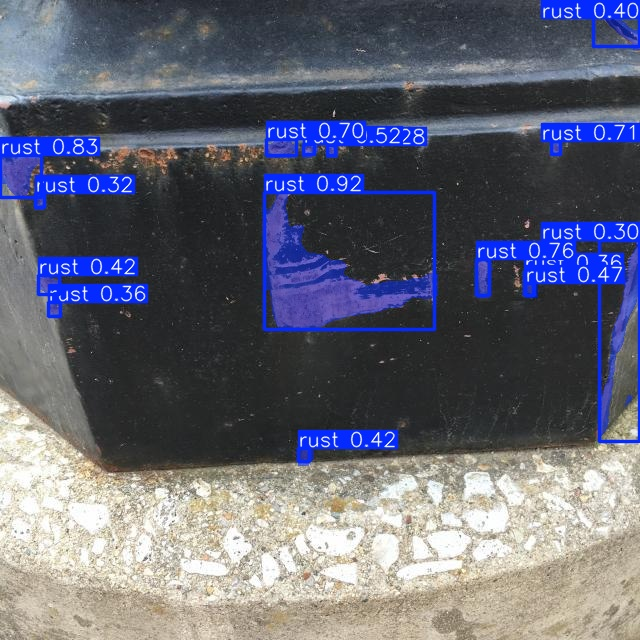

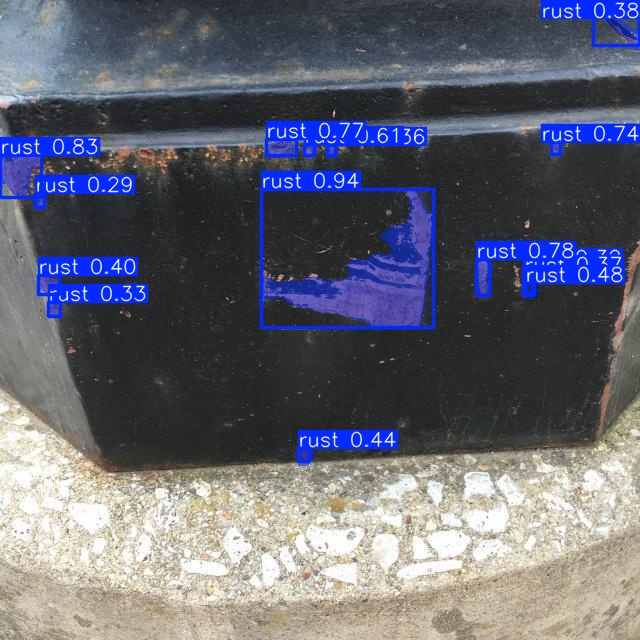

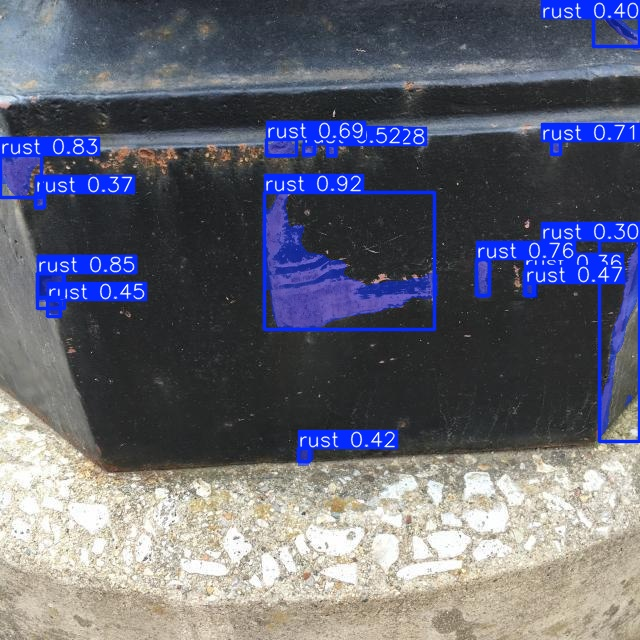

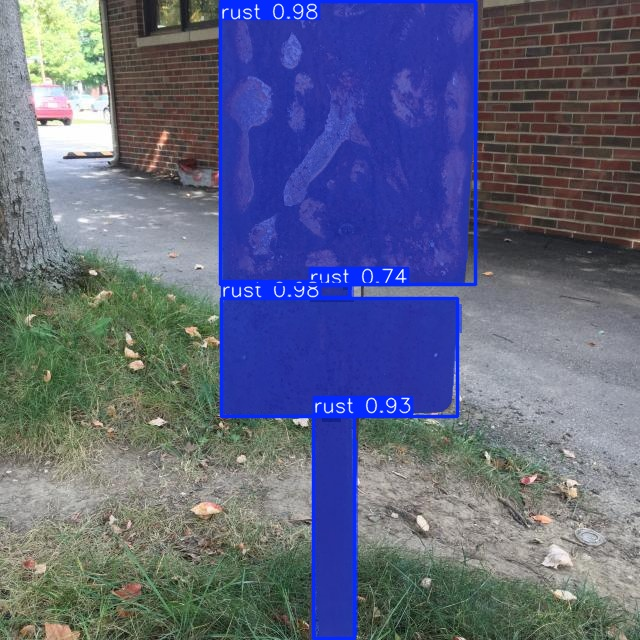

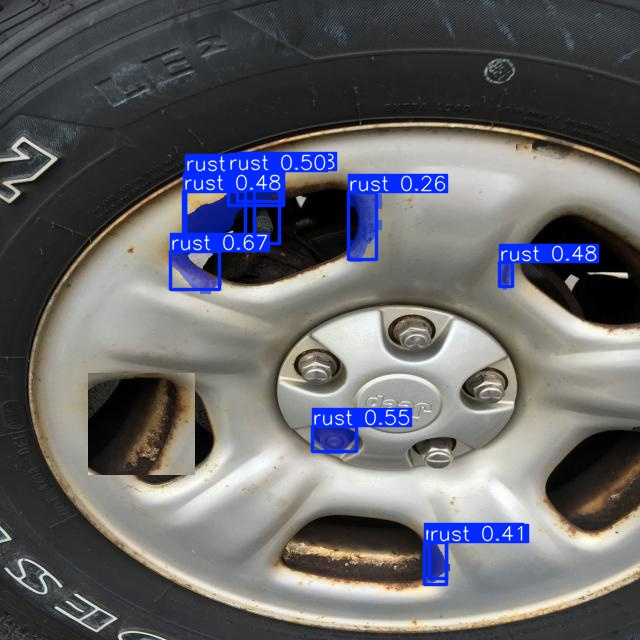

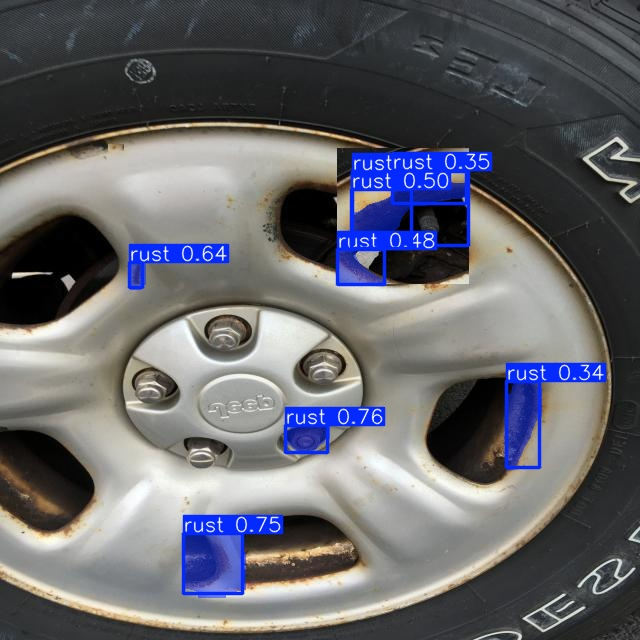

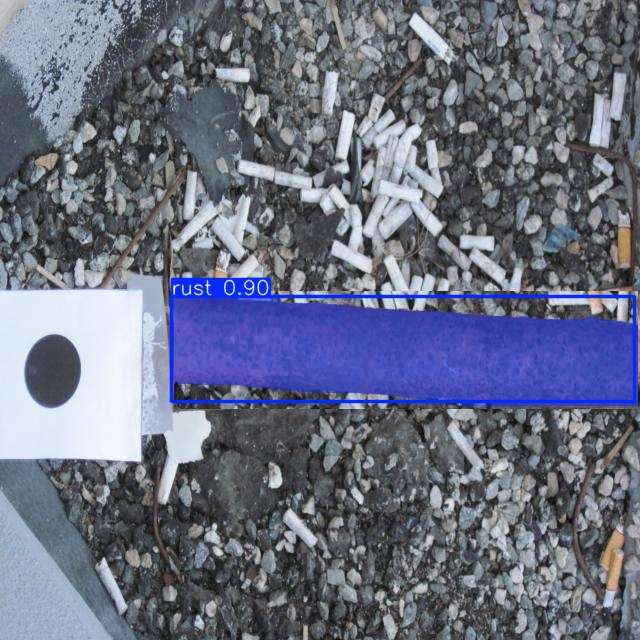

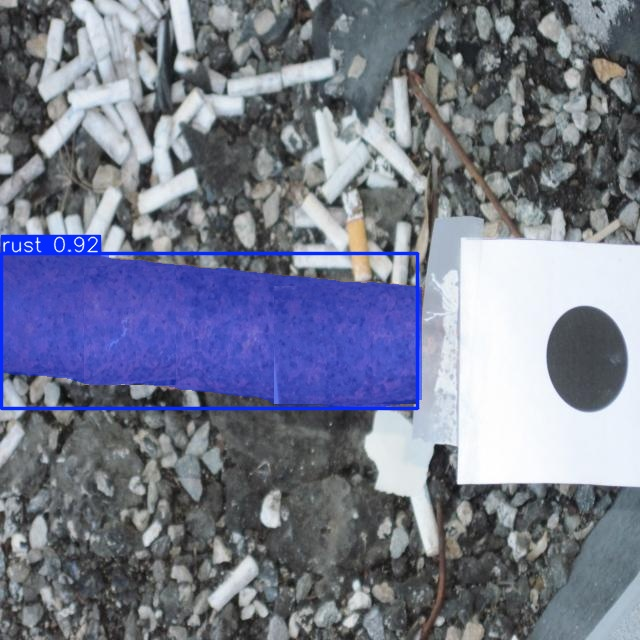

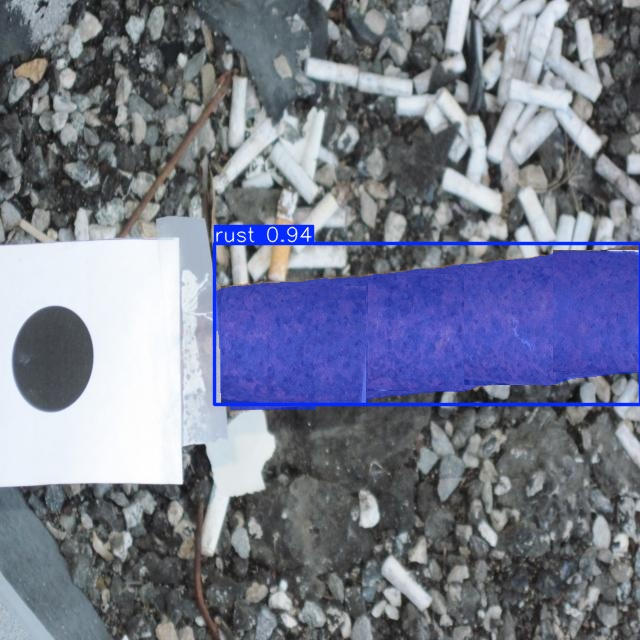

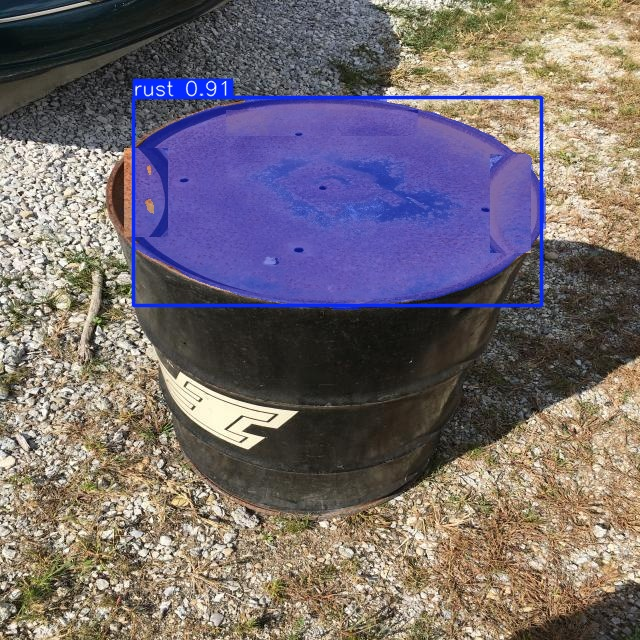

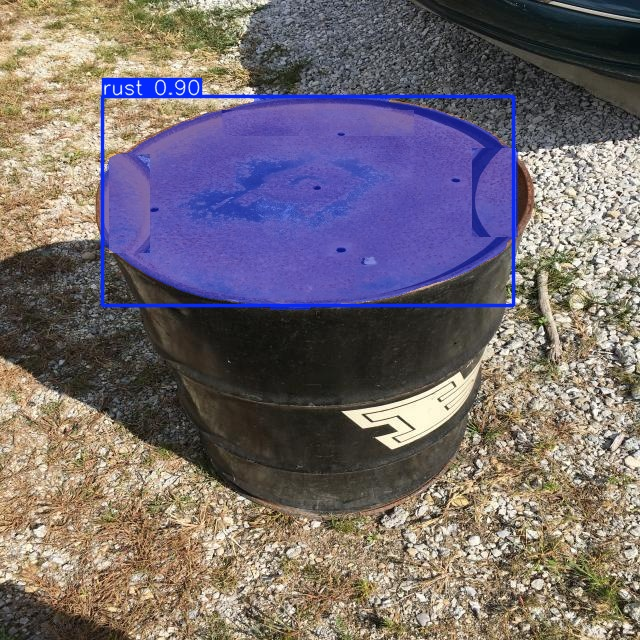

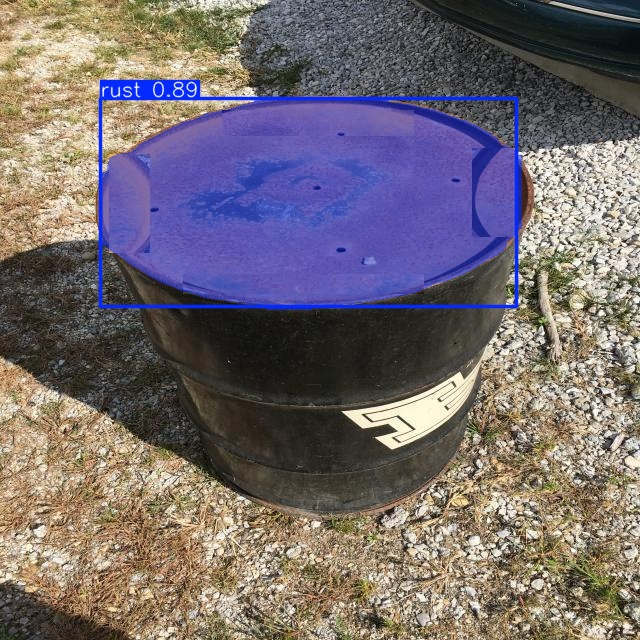

In [ ]:
import glob
from IPython.display import Image, display

pred_dir = "/content/drive/MyDrive/yolo_runs/rust_pred12"
imgs = sorted(glob.glob(pred_dir + "/*.jpg"))[:12]
print("preview from:", pred_dir, "->", len(imgs), "images")
for p in imgs:
    display(Image(p))

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/yolo_runs/rust_run12/results.csv")
df.tail(1)  # 最終行だけ表示

,epoch,time,train/box_loss,train/seg_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),...,metrics/recall(M),metrics/mAP50(M),metrics/mAP50-95(M),val/box_loss,val/seg_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
49,50,1060.95,1.14887,2.23122,1.14615,1.18762,0.61551,0.56581,0.5675,0.37835,...,0.53187,0.55588,0.3167,1.19252,2.489,1.2594,1.23215,0.00006,0.00006,0.00006
